# Prepare tensorflow-model-optimization

In [1]:
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tensorflow-gpu==1.14.0

! pip install tensorflow-model-optimization

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 377.0MB 37kB/s 
     |████████████████████████████████| 491kB 38.5MB/s 
     |████████████████████████████████| 3.2MB 45.1MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
     |████████████████████████████████| 102kB 2.8MB/s 


In [1]:
%load_ext tensorboard
import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#Download dataset from Google Drive

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8/view?usp=sharing
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8
download = drive.CreateFile({'id': '1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8'})
download.GetContentFile('weed_dataset_w25.hdf5')

# Read Dataset

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from operator import truediv
import h5py
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix

import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os


In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
LOAD HDF5 FILE
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

hdf5_file = h5py.File('weed_dataset_w25.hdf5', "r")
train_x = np.array(hdf5_file["train_img"][...])
# train_x = train_x / np.max(train_x)
# train_x = np.clip(train_x, 0, 1)
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))
train_y = np.array(hdf5_file["train_labels"][...])

# Average consecutive bands
img2 = np.zeros((train_x.shape[0], train_x.shape[1], train_x.shape[2], int(train_x.shape[3]/2)))
for n in range(0, train_x.shape[0]):
    # Average consecutive bands
    for i in range(0, train_x.shape[3], 2):
        img2[n, :, :, int(i/2)] = (train_x[n, :, :, i] + train_x[n, :, :, i + 1]) / 2.

train_x = img2

print(train_x.shape)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))

(6316, 25, 25, 150)


# Calculate loss after removing one spectral band

In [9]:
data = 'WEED'
windowSize = train_x.shape[1]
classes = 3

tf.keras.backend.clear_session()
# Load trained pruned network
#loaded_model = tf.keras.models.load_model("Kochia_hyper3DNet_pruned.h5")

# Load model without pruning
loaded_model = tf.keras.models.load_model("weights-hyper3dnetWEED1-best_3layers_4filters.h5")

loaded_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
import pickle
from tensorflow_model_optimization.sparsity import keras as sparsity

windowSize = train_x.shape[1]
classes = 3
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

epochs = 8
batch_size = 32;
num_train_samples = train_x.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

data = 'WEED'
SA = np.zeros((10, train_x.shape[3],))
ntrain = 1
for train, test in kfold.split(train_x, train_y):

    new_pruning_params = {
          'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.10,
                                                      final_sparsity=0.30,
                                                      begin_step=0,
                                                      end_step=end_step,
                                                      frequency=100)
    }
    new_pruned_model = sparsity.prune_low_magnitude(loaded_model, **new_pruning_params)
    new_pruned_model.load_weights("pruned-weights-hyper3dnet" + data + str(ntrain) + "-best_3layers_4filters.h5")

    ytest = tf.keras.utils.to_categorical(train_y[test]).astype(np.int32) 
    ypred1 = new_pruned_model.predict(train_x[test])
    loss1 = tf.keras.losses.categorical_crossentropy(ytest, ypred1)
    print("Fold:" + str(ntrain) +" , original accuracy: " + str(np.sum(ypred1*ytest)/len(ytest)))
    for nchannel in range(0, train_x.shape[3]):
      xtest = train_x[test].copy()
      xtest[:, :, :, nchannel, :] = np.zeros((train_x[test].shape[0], train_x.shape[1], train_x.shape[2], 1))
      ypred2 = new_pruned_model.predict(xtest)
      loss2 = tf.keras.losses.categorical_crossentropy(ytest, ypred2)
      print("Analyzing channel " +str(nchannel) + ": " + str(np.sum(ypred2*ytest)/len(ytest)))
      SA[ntrain-1][nchannel] = np.sum(abs(loss2 - loss1))

    with open('SA_fold_pruning'+str(ntrain), 'wb') as f:
      pickle.dump(SA[ntrain-1], f)

    ntrain += 1;

Fold:1 , original accuracy: 0.9953558429651246
Analyzing channel 0: 0.8342226479382047
Analyzing channel 1: 0.6105839337661964
Analyzing channel 2: 0.4268358653617662
Analyzing channel 3: 0.496603516582771
Analyzing channel 4: 0.5142832622673656
Analyzing channel 5: 0.5288651555275641
Analyzing channel 6: 0.5707167550310274
Analyzing channel 7: 0.6611819107783793
Analyzing channel 8: 0.27420311729532193
Analyzing channel 9: 0.19655478906110438
Analyzing channel 10: 0.20009457822876306
Analyzing channel 11: 0.44348721966046595
Analyzing channel 12: 0.4705875334931208
Analyzing channel 13: 0.5732577539995601
Analyzing channel 14: 0.41927236149103414
Analyzing channel 15: 0.4575623515204244
Analyzing channel 16: 0.46960856832678505
Analyzing channel 17: 0.3860838867674342
Analyzing channel 18: 0.7741514511143089
Analyzing channel 19: 0.5229099739791087
Analyzing channel 20: 0.3785594559500892
Analyzing channel 21: 0.4353424371287277
Analyzing channel 22: 0.5478884375522636
Analyzing chann

No handles with labels found to put in legend.


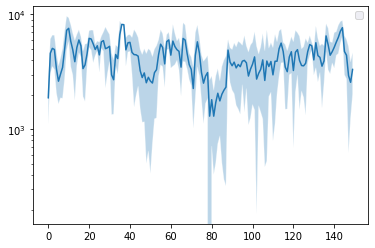

In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

means = np.mean(SA, axis=0)
stds = np.std(SA, axis=0)

fig, ax = plt.subplots()
clrs = sns.color_palette()
with sns.axes_style("darkgrid"):
    epochs = list(range(150))
    
    ax.plot(epochs, means, c=clrs[0])
    ax.fill_between(epochs, means-stds, means+stds ,alpha=0.3, facecolor=clrs[0])
    ax.legend()
    ax.set_yscale('log')

plt.savefig('Bands_importance_plotKochiahyper3dnet_crossvalidation.png', dpi=1200)



Printing saliency and spectral band
Spectral band: 36	Saliency: 8192.02919921875
Spectral band: 37	Saliency: 8151.763232421875
Spectral band: 144	Saliency: 7678.441796875
Spectral band: 10	Saliency: 7573.884814453125
Spectral band: 9	Saliency: 7285.657675170898
Spectral band: 143	Saliency: 7141.88623046875
Spectral band: 35	Saliency: 6653.0816650390625
Spectral band: 136	Saliency: 6505.809326171875
Spectral band: 142	Saliency: 6316.901220703125
Spectral band: 20	Saliency: 6193.44091796875
Spectral band: 66	Saliency: 6184.717175292969
Spectral band: 21	Saliency: 6114.614599609375
Spectral band: 59	Saliency: 6001.00771484375
Spectral band: 15	Saliency: 5999.9171142578125
Spectral band: 67	Saliency: 5987.969287109375
Spectral band: 27	Saliency: 5921.92666015625
Spectral band: 61	Saliency: 5864.17119140625
Spectral band: 11	Saliency: 5855.361279296875
Spectral band: 58	Saliency: 5806.661962890625
Spectral band: 73	Saliency: 5780.043872070312
Spectral band: 26	Saliency: 5770.706982421875


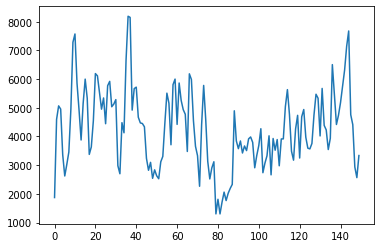

In [27]:
list_importance = list(zip(means, range(0, 150)))
sortedlist = sorted(list_importance, key = lambda x: x[0], reverse=True)
print('\n\nPrinting saliency and spectral band')
for x in sortedlist: 
    print("Spectral band: " + str(x[1]) + "\tSaliency: " + str(x[0])) 

import matplotlib.pyplot as plt
plt.plot(means)



Printing saliency and spectral band
Spectral band: 36	Saliency: 81678.6953125
Spectral band: 37	Saliency: 81678.6953125
Spectral band: 106	Saliency: 81671.625
Spectral band: 105	Saliency: 81664.65625
Spectral band: 113	Saliency: 81654.6328125
Spectral band: 143	Saliency: 81615.25
Spectral band: 131	Saliency: 81587.1328125
Spectral band: 114	Saliency: 81524.890625
Spectral band: 9	Saliency: 80922.2109375
Spectral band: 10	Saliency: 80875.0
Spectral band: 144	Saliency: 80867.125
Spectral band: 121	Saliency: 80778.640625
Spectral band: 66	Saliency: 80561.0859375
Spectral band: 122	Saliency: 77923.703125
Spectral band: 101	Saliency: 77636.6015625
Spectral band: 43	Saliency: 77511.6484375
Spectral band: 2	Saliency: 75515.75
Spectral band: 107	Saliency: 75334.578125
Spectral band: 73	Saliency: 74608.6484375
Spectral band: 132	Saliency: 73089.46875
Spectral band: 123	Saliency: 71481.125
Spectral band: 72	Saliency: 71100.375
Spectral band: 61	Saliency: 71073.0234375
Spectral band: 55	Salienc

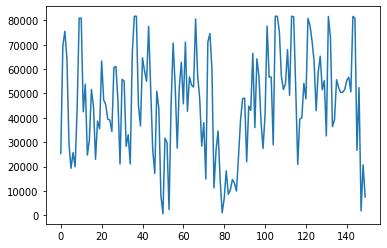

In [0]:
list_importance = list(zip(SA, range(0, 150)))
sortedlist = sorted(list_importance, key = lambda x: x[0], reverse=True)
print('\n\nPrinting saliency and spectral band')
for x in sortedlist: 
    print("Spectral band: " + str(x[1]) + "\tSaliency: " + str(x[0])) 

import matplotlib.pyplot as plt
plt.plot(SA)

In [0]:
list_importance = list(zip(SA, range(0, 150)))
sortedlist = sorted(list_importance, key = lambda x: x[0], reverse=True)
print('\n\nPrinting saliency and spectral band')
for x in sortedlist: 
    print("Spectral band: " + str(x[1]) + "\tSaliency: " + str(x[0])) 



Printing saliency and spectral band
Spectral band: 36	Saliency: 82089.5
Spectral band: 37	Saliency: 82089.5
Spectral band: 106	Saliency: 82074.984375
Spectral band: 105	Saliency: 82073.3828125
Spectral band: 114	Saliency: 82067.8984375
Spectral band: 113	Saliency: 82055.578125
Spectral band: 131	Saliency: 82032.3359375
Spectral band: 10	Saliency: 81320.0546875
Spectral band: 144	Saliency: 81296.984375
Spectral band: 143	Saliency: 81197.9375
Spectral band: 121	Saliency: 81050.15625
Spectral band: 9	Saliency: 80802.09375
Spectral band: 101	Saliency: 80750.65625
Spectral band: 107	Saliency: 78979.046875
Spectral band: 122	Saliency: 77152.15625
Spectral band: 132	Saliency: 76973.28125
Spectral band: 43	Saliency: 76287.4375
Spectral band: 111	Saliency: 76177.6171875
Spectral band: 66	Saliency: 73835.046875
Spectral band: 55	Saliency: 73312.65625
Spectral band: 2	Saliency: 72819.109375
Spectral band: 35	Saliency: 70886.59375
Spectral band: 73	Saliency: 69047.4296875
Spectral band: 61	Salie

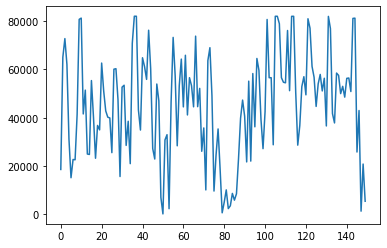

In [0]:
import matplotlib.pyplot as plt
plt.plot(SA)